Extracting comments from Youtube comment section

In [1]:
import os
import json
import pandas as pd
from googleapiclient.discovery import build

# Set your API key here
API_KEY = 'Enter_Your_API_Key'

# Create a YouTube resource object
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_video_comments(video_id):
    comments = []
    try:
        # Retrieve the comments
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            textFormat='plainText',
            maxResults=100  # Change this if you want more comments in one call
        ).execute()

        # Loop through the response
        while response:
            for item in response['items']:
                comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                comments.append(comment)

            # Check for more pages of comments
            if 'nextPageToken' in response:
                response = youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    textFormat='plainText',
                    pageToken=response['nextPageToken'],
                    maxResults=100
                ).execute()
            else:
                break

    except Exception as e:
        print(f"An error occurred: {e}")

    return comments

def save_comments_to_excel(comments, video_id):
    # Create a DataFrame from the comments list
    df = pd.DataFrame(comments, columns=['Comment'])

    # Save the DataFrame to an Excel file
    excel_file_name = f'comments_{video_id}.xlsx'
    df.to_excel(excel_file_name, index=False)

    print(f"Comments saved to {excel_file_name}")

# Example usage
video_id = '_InqQJRqGW4'  # Replace with your YouTube video ID
comments = get_video_comments(video_id)

# Save comments to Excel
save_comments_to_excel(comments, video_id)


Comments saved to comments__InqQJRqGW4.xlsx


Data Preprocessing on the extracted comments

In [2]:
# importing libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [4]:
# Step 1: Load the Excel data
file_path = "/content/comments__InqQJRqGW4.xlsx"
df = pd.read_excel(file_path)

# Check the first few rows to ensure the data is loaded correctly
print(df.head())


                                             Comment
0                                     Anyone in 2025
1                                       Anyone 2025❤
2                           The Korean one is better
3  I seen this series 9 or 10 times I love this s...
4                               2025 Attendance Here


In [5]:
# Step 2: Lowercase all comments
df['Comment'] = df['Comment'].str.lower()


In [6]:
# Step 3: Remove special characters, punctuation, and URLs
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove mentions, hashtags, and special characters
    text = re.sub(r'\@\w+|\#|\d+', '', text)
    # Remove punctuations and numbers
    text = re.sub(r'[^\w\s]', '', text)
    return text

cleaned_comments = [clean_text(comment) for comment in comments]

In [7]:
# Step 4: Tokenization
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # Download the 'punkt_tab' data
tokenized_comments = [word_tokenize(comment) for comment in cleaned_comments]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
# Step 5: Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
filtered_comments = []
for comment in tokenized_comments:
    filtered_comments.append([word for word in comment if word not in stop_words])

In [11]:
# Step 6 : Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
lemmatized_comments = []
for comment in filtered_comments:
    lemmatized_comments.append([lemmatizer.lemmatize(word)
     for word in comment])

# Final Preprocessed Data
preprocessed_comments = [" ".join(comment)
 for comment in lemmatized_comments]

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
# Step 7: Save cleaned data back to Excel
df['Cleaned_Comments'] = preprocessed_comments
df.to_csv("cleaned_comments_hinglish.xlsx", index=False)

print("Preprocessing complete! Cleaned data saved to 'cleaned_comments_hinglish.csv'.")

Preprocessing complete! Cleaned data saved to 'cleaned_comments_hinglish.csv'.


Implementing VADER (Valence Aware Dictionary and sEntiment Reasoner) for Sentiment Analysis :

In [13]:
# importing libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [14]:
# Step 1: Load the cleaned data
file_path = "/content/cleaned_comments_hinglish.xlsx"
df = pd.read_csv(file_path)

In [15]:
# Step 2: Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [16]:
# Step 3: Define a function to classify sentiment
def classify_sentiment(comment):
    # Convert comment to string if it's not already
    comment = str(comment)
    score = sia.polarity_scores(comment)
    if score['compound'] > -0.01 and score['compound'] < 0.01:
        return 'Neutral'
    elif score['compound'] >= 0.01:
        return 'Positive'
    else :
        return 'Negative'


In [17]:
# Step 4: Apply sentiment classification to each cleaned comment
df['Sentiment'] = df['Cleaned_Comments'].apply(classify_sentiment)

In [18]:
# Step 5: Count the number of Positive,
# Negative, and Neutral comments
sentiment_counts = df['Sentiment'].value_counts()

print("Sentiment Counts:")
print(sentiment_counts)

Sentiment Counts:
Sentiment
Neutral     1174
Positive    1067
Negative     350
Name: count, dtype: int64


In [19]:
# Step 6: Save the results to a new Excel file
df.to_csv("comments_with_sentiment.csv", index=False)

print("Sentiment analysis complete! Results saved to 'comments_with_sentiment.csv'.")

Sentiment analysis complete! Results saved to 'comments_with_sentiment.csv'.


Visualization of sentiments

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# Load your balanced dataset
df_balanced = pd.read_csv('/content/comments_with_sentiment.csv')

# Count the number of sentiments
sentiment_counts = df_balanced['Sentiment'].value_counts()

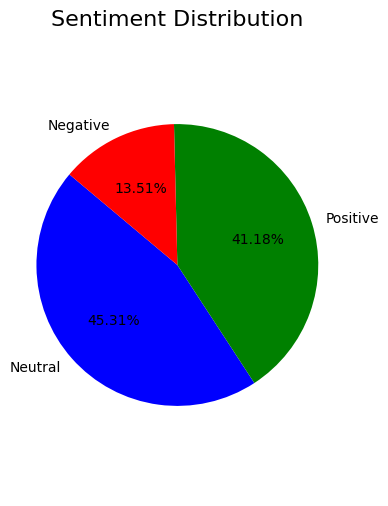

In [23]:
# Create a pie chart
plt.figure(figsize=(4, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%0.2f%%', startangle=140, colors=['blue', 'green', 'red'])

# Add title
plt.title('Sentiment Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot

plt.show()

Model Building : Random Forest

In [46]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
# Load your dataset (replace this with your actual dataset)
df = pd.read_csv('/content/comments_with_sentiment.csv')

# Step 1: Preprocess the data
# Separate features (X) and target (y)
X = df['Cleaned_Comments']
y = df['Sentiment']

In [48]:
# Step 2: Encode labels

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [49]:
# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [51]:
# *** Handle missing values in X_train and X_test ***
X_train = X_train.fillna('')
X_test = X_test.fillna('')

In [52]:
# Step 4: Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [53]:
# Step 5: Build the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test_tfidf)

# Step 7: Evaluate the model
# Decode labels back to their original form for interpretability
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

In [54]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=label_encoder.classes_)
print("\nConfusion Matrix:")
print(cm)

Accuracy: 81.12%

Confusion Matrix:
[[ 25  25  21]
 [  0 219  10]
 [  6  36 177]]


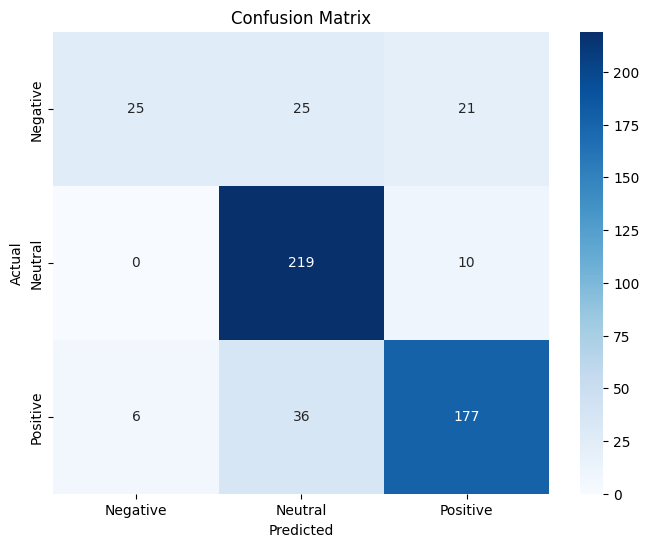

In [55]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [56]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test_decoded, y_pred_decoded, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.35      0.49        71
     Neutral       0.78      0.96      0.86       229
    Positive       0.85      0.81      0.83       219

    accuracy                           0.81       519
   macro avg       0.81      0.71      0.73       519
weighted avg       0.81      0.81      0.80       519

